<a href="https://www.kaggle.com/code/ibrahimnibrahim/youtube-comments-75-cnn-lstm?scriptVersionId=244285990" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-comments-dataset/YoutubeCommentsDataSet.csv


In [2]:
data=pd.read_csv('/kaggle/input/youtube-comments-dataset/YoutubeCommentsDataSet.csv')
data.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


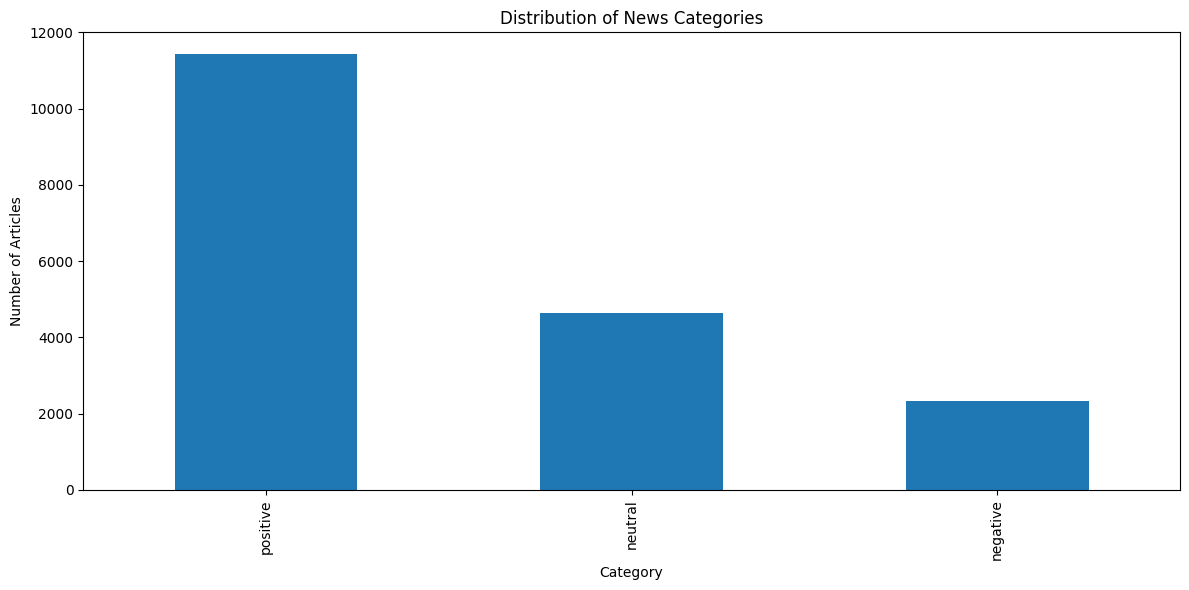

In [3]:
import matplotlib.pyplot as plt
# Count unique categories
category_counts = data['Sentiment'].value_counts()

# Plot the category distribution
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [4]:
import nltk
from nltk.corpus import stopwords

text=data['Comment'].apply(lambda x: str(x).split())
labels=data['Sentiment']

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

text=text.apply(lambda x : ' '.join([word for word in x if word not in stop_words]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import tensorflow as tf

vectorized_layer=tf.keras.layers.TextVectorization(ragged=True,max_tokens=20000)
vectorized_layer.adapt(text)

sequence=vectorized_layer(text)

padded=tf.keras.utils.pad_sequences(
    sequence.numpy(),
    maxlen=60,
    padding='pre',
    truncating='pre',
)


In [6]:
label_vectorizer=tf.keras.layers.StringLookup(num_oov_indices=0)
label_vectorizer.adapt(labels)
labels=label_vectorizer(labels)

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(padded, labels.numpy(), test_size=0.2, random_state=101)

In [8]:
text_train=tf.data.Dataset.from_tensor_slices(text_train)
text_test=tf.data.Dataset.from_tensor_slices(text_test)

labels_train=tf.data.Dataset.from_tensor_slices(labels_train)
labels_test=tf.data.Dataset.from_tensor_slices(labels_test)

train_dataset=tf.data.Dataset.zip(text_train,labels_train)
test_dataset=tf.data.Dataset.zip(text_test,labels_test)

In [9]:
train_dataset=train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE).batch(32)
test_dataset=test_dataset.cache().prefetch(tf.data.AUTOTUNE).batch(32)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(60,)),
    tf.keras.layers.Embedding(input_dim=20000, output_dim=128,),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(label_vectorizer.get_vocabulary()), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 60, 128)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 58, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 58, 40)              │          23,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 58, 20)              │           4,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1160)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         297,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,935,187 (11.20 MB)

 Trainable params: 2,935,187 (11.20 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
es=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

In [13]:
history = model.fit(train_dataset, epochs=15, validation_data=test_dataset,callbacks=[es,])

Epoch 1/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6743 - loss: 0.7648 - val_accuracy: 0.7537 - val_loss: 0.5795
Epoch 2/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8138 - loss: 0.4409 - val_accuracy: 0.7442 - val_loss: 0.6836
Epoch 3/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9239 - loss: 0.2013 - val_accuracy: 0.7317 - val_loss: 1.0639
Epoch 4/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9666 - loss: 0.0921 - val_accuracy: 0.7238 - val_loss: 1.2899
Epoch 5/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9783 - loss: 0.0595 - val_accuracy: 0.7192 - val_loss: 1.4427
Epoch 6/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9838 - loss: 0.0446 - val_accuracy: 0.7219 - val_loss: 1.6899
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
